### Title: Box Jenkins Methods- Dimension Reduction

Author: Yiran Jing

Date: 11-10-2018

- Using three selected products first, which are currently just pizza. No missing values, so all 156 observations are present.

- We try dimension reduction and modelling these three products separately. 
- delete HHS and SPEDN

### Summary
Based on dimension reduction, the choice for the top 5 regressors, which can explain more than 90% overall variation
are 



- HHS # of purchasing households
- VISITS # number of unique purchases (baskets) that included the product
- SPEND  # total spend 
- DISPLAY # Product was a part of in-store promotional display
- FEATURE # product was in in-store circular


1. Seems price is the least useful regressor, base-price is also not useful.
3. All regerssors are stationary.
4. Will try 5-8 regressors tomorrow, but based on plot, intuitively thinking 5 regressors is good enough.
5. Using m = 5 predictors, VAR(1) still chosen. 
6. ARMAX tomorrow.

### Dimension Reduction

- Dimension Reduction reduces the number of input variables/features.
- If we have $p$ input features we can reduce it down to a smaller number $k$ where $k << p$.

#### Why? 

1. Bring the number of most valueable features.
2. Removes redundant information
    - Sometimes in our data there is redundancy, which is sometimes called multicolinearity. This means that some features tell us the exact same thing. We should remove these redundant features because they do not contribute to our model and only serve to increase computational requirements.
    - In some cases removing multilinear features can improve the performance of the model

3. Reduces computational requirements.

### Time Series Modelling Pipeline

The principle we based on

1. **Feature selection** : dimention reduction based on Principal Component Analysis
1. **Plot data** : identify any unusual observations, understand parrtern by time decomposition plots
2. **Stabilze variance** : if necessary, transform data by log/box-cox
3. **Difference-stationary** : Based on Plot, differenced data if necessary, generally first or/and seasonal difference. Then, try hypoithesis test to check stationary. 
4. **ACF/PACF plot** : plot differenced data to identify candidate models
5. **Model selection** : test the set of chosen models, selected by MAPE and AIC!
6. **Residual plot** : Plotting ACF of residuals and doing tests to see if white noise, try different models if not white noise
7. **Forecast** : After the residuals look like white noise, calculate the forecast. We use **rolling window and expanding window**  for point forecast, and calculate **bootstrap CI**


-**VAR model**


-**ARMAX model**


#### Insights



In [9]:
from collections import Counter
import pandas as pd
import csv
import pprint
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from collections import defaultdict
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas import Series
from matplotlib import pyplot
from time_series import ts_plot,ts_plot2,ts_plot3,acf_pacf_plot,hist,modify_time_format,epoch_seconds_to_timestamp
from time_series import pd_read_obs_csv # function used for read SA weather obs
import statsmodels.api as sm
import seaborn as sns
import datetime
import glob, os
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from sklearn.decomposition import PCA

%matplotlib inline

### Dataset Description
- **product_of_interest** (all pizza)

1111087398,
1111087395, 
1111087396

- **Attribute**
- meaning of each attribute in  $dictionary.csv$
- all attributes in the original dataset: $transcation.csv$
- add category for each product, based on the $product.csv$, and transfer them to dummy (for each induvidual product preduction, category is not useful, so ignore them first)
- add holiday dummy variable 
Different categories can have different holiday dummy decision. All information based on the EDA time series plots
#### Holiday dummy:
There are two kinds of holiday dummy:
1. holiday_higher_U: during holiday, the units increase significantly, while price decrease
2. holiday_higher_P: during holiday, the price increase significantly, while unit decrease

In [10]:
data_transactions = pd.read_csv('../../intellify_data/three_prod_trans_category_holiday.csv')
final_trans = data_transactions.rename(columns={"WEEK_END_DATE": "Date"})
#data_transactions.head()

In [11]:
# read data and change variable name, set index
data_transactions = pd.read_csv('../../intellify_data/three_prod_trans_category_holiday.csv')
final_trans = data_transactions.rename(columns={"WEEK_END_DATE": "Date"})

# First, fix ordering of dataset by time series.
weekly_date = dates_from_str(final_trans.Date)
final_trans.Date = weekly_date
final_trans["Date"] = pd.to_datetime(final_trans.Date)
final_trans = final_trans.sort_values(by="Date")

# Dataset is weekly data, so get datetime version to later set as index. 
weekly_date = final_trans.Date

# Update index to get datetime index.
final_trans.index = pd.DatetimeIndex(weekly_date)
del final_trans["Date"]
del final_trans["STORE_NUM"] # not useful in feature selection
del final_trans['SPEND']
del final_trans['HHS']

#### Split the data into Training set and Testing set
- obs in train dataset: 125
- obs in test dataset: 31

In [12]:
train_data = final_trans[final_trans.index <= "2011-06-01"]
val_data = final_trans[final_trans.index > "2011-06-01"]

#### Separate dataset for each product

In [13]:
## separate three products for train and test dataset
prod_one_train = train_data[train_data['UPC'] == 1111087398] 
prod_two_train = train_data[train_data['UPC'] == 1111087395] 
prod_three_train = train_data[train_data['UPC'] == 1111087396] 

prod_one_test = val_data[val_data['UPC'] == 1111087398] 
prod_two_test = val_data[val_data['UPC'] == 1111087395] 
prod_three_test = val_data[val_data['UPC'] == 1111087396] 

#### Separate response and potentional regressors

In [14]:
# Pick out all the columns
bad_columns = ['VISITS', 'PRICE', 'BASE_PRICE', 'FEATURE',
               'DISPLAY', 'TPR_ONLY', 'holiday_higher_U', 'holiday_higher_P']

In [15]:
def separate_x_y(bad_columns, response, train, test):
    """
    Separate X and Y of train and test dataset
    
    Parameters
    --------
    bad_columns:
        All the columns which shall be considered in PCA
    response: 
        Predictor 
    train, test: 
        The training and test datasets.
    
    Returns
    --------
    results: Four datasets
        X_train, y_train, X_test, y_test
    """
    y_train = train[response]
    y_test = test[response]
    X_train = train[bad_columns]
    X_test = test[bad_columns]
    
    return X_train, y_train, X_test, y_test

In [16]:
p1_X_train, p1_y_train, p1_X_test, p1_y_test = separate_x_y(bad_columns, 'UNITS', prod_one_train, prod_one_test)
p2_X_train, p2_y_train, p2_X_test, p2_y_test = separate_x_y(bad_columns, 'UNITS', prod_two_train, prod_two_test)
p3_X_train, p3_y_train, p3_X_test, p3_y_test = separate_x_y(bad_columns, 'UNITS', prod_three_train, prod_three_test)

### Step1:  Dimention Reduction by PCA
** PCA** : most popular method for dimensionality reduction

#### Standardize  Regressors
As we want to keep the transformation (standardization) the same across all data

Make the mean of our data approximately 0 and the std of our data approximately 1


In [17]:
def Standardize(x_train, x_test):
    '''
    Standardize Regressors used in PCA
    Note that the x_test_norm shall use the mean and std form the training data
    
    Parameters
    --------
    x_train: Regressors of training data
    x_test: Regressors of test data
    
    '''
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train_norm = (x_train - x_train_mean) / x_train_std
    x_test_norm = (x_test - x_train_mean) / x_train_std
    return x_train_norm, x_test_norm

In [18]:
p1_X_train_norm, p1_X_test_norm = Standardize(p1_X_train, p1_X_test)
p2_X_train_norm, p2_X_test_norm = Standardize(p2_X_train, p2_X_test)
p3_X_train_norm, p3_X_test_norm = Standardize(p3_X_train, p3_X_test)

### Selecting number of components
There are numerous methods to select a suitable number of components including:
- Scree plot (total variance)
- Elbow method
- Cross Validation

##### Scree Plot

At some point we will be satisfied with the amount of variance. We might set this threshold at 95%, 90% or 85%.

In [19]:
X_train_norm = [p1_X_train_norm, p2_X_train_norm, p3_X_train_norm]

In [22]:
def Scree_plot(X_train_norm):
    '''
    Scree_plot
    shows the proportion of total explained variance against the number of principal components. 
    As the number of components approaches infinity the total explained varianced approaches 100%.
    
    x_axis:
    Number of Components (1-10)
    y_axis:
    Proportion of total explained variance
    
    Parameters
    --------
    Standardized X training data
    
    Returns
    --------
    Scree Plot
    '''
    
    %matplotlib inline
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    pca1 = PCA()
    pca1.fit(X_train_norm[0])
    cum_var1 = np.cumsum(pca1.explained_variance_ratio_) * 100
    plt.subplot(1,3,1)
    plt.plot(np.arange(1, 9), cum_var1, marker = "o")
    plt.xlabel("Number of Components", fontsize=18)
    plt.ylabel("Proportion of Variance", fontsize=18)
    plt.title("Product One", fontsize=25)
    
    pca2 = PCA()
    pca2.fit(X_train_norm[1])
    cum_var2 = np.cumsum(pca2.explained_variance_ratio_) * 100
    plt.subplot(1,3,2)
    plt.plot(np.arange(1, 9), cum_var2, marker = "o")
    plt.xlabel("Number of Components", fontsize=18)
    plt.ylabel("Proportion of Variance", fontsize=18)
    plt.title("Product Two", fontsize=25)
    
    pca3 = PCA()
    pca3.fit(X_train_norm[2])
    cum_var3 = np.cumsum(pca3.explained_variance_ratio_) * 100
    plt.subplot(1,3,3)
    plt.plot(np.arange(1, 9), cum_var3, marker = "o")
    plt.xlabel("Number of Components", fontsize=18)
    plt.ylabel("Proportion of Variance", fontsize=18)
    plt.title("Product Three", fontsize=25)
    
    # check I really deal with different products
    if set(cum_var1) == set(cum_var2) or set(cum_var1) == set(cum_var3) \
        or set(cum_var2) == set(cum_var3):
        print("Error")
    
    # Fix up the spacing.
    plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
    plt.show()

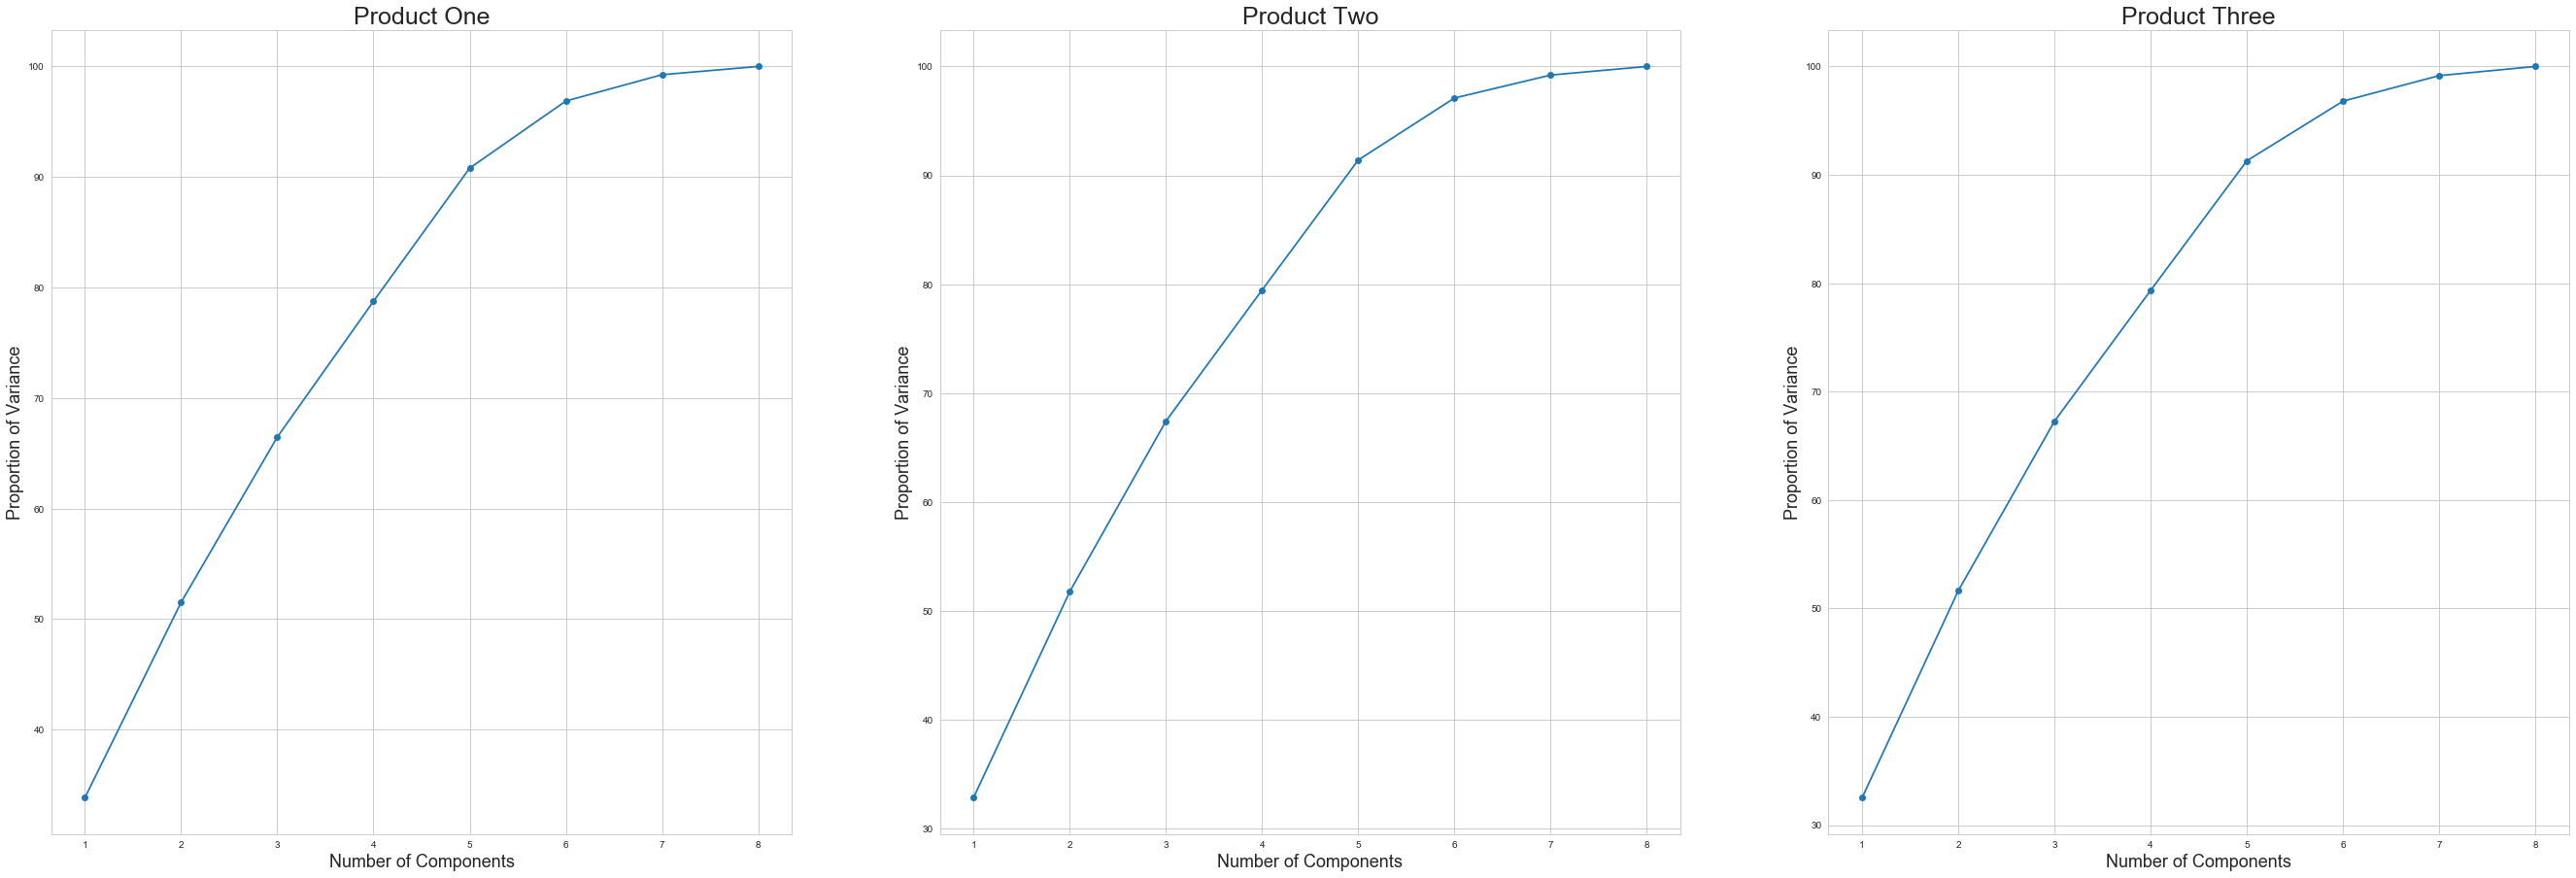

In [23]:
Scree_plot(X_train_norm)

Three products show quite similar results (but actully, not same)

In all case it seems that over 90% of the variance can be explained from the first 5 dimensions!

The slope decrease after m=5, so we condiser select 5-8 components in our model

##### Visualisation of Principal Component Weights

In [24]:
def Visualisation_PCA_Weights(X_train_norm):
    '''
    Visualisation Principal Component Weights:
    
    The magnitude of values in a principal component reflect how much the variable contributes to the component.
    The magnitude is relative not absolute. i.e. The positive weight has higher weight than negative ones
    
    Parameters
    --------
    Standardized X training data
    
    '''
    
    %matplotlib inline
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows=1, ncols=3)
    
    pca = PCA()
    pca.fit(X_train_norm[0])
    plt.subplot(1,3,1)
    first_component_weights = pd.DataFrame({'Weight': pca.components_[0], 'Feature': X_train_norm[0].columns})
    first_component_weights = first_component_weights.sort_values('Weight')
    test = first_component_weights
    test = test.reset_index(drop = True)
    first_component_weights = first_component_weights.reset_index(drop=True)
    plt.title("Product One", fontsize=25)
    plt.bar(np.arange(len(first_component_weights)), first_component_weights['Weight'])
    plt.xticks(np.arange(len(first_component_weights)), first_component_weights['Feature'],
              rotation = 30, horizontalalignment = "right",fontsize=18)

    
    pca = PCA()
    pca.fit(X_train_norm[1])
    plt.subplot(1,3,2)
    first_component_weights = pd.DataFrame({'Weight': pca.components_[0], 'Feature': X_train_norm[1].columns})
    first_component_weights = first_component_weights.sort_values('Weight')
    test = first_component_weights
    test = test.reset_index(drop = True)
    first_component_weights = first_component_weights.reset_index(drop=True)
    plt.title("Product Two", fontsize=25)
    plt.bar(np.arange(len(first_component_weights)), first_component_weights['Weight'])
    plt.xticks(np.arange(len(first_component_weights)), first_component_weights['Feature'],
              rotation = 30, horizontalalignment = "right", fontsize=18)
    
    pca = PCA()
    pca.fit(X_train_norm[2])
    plt.subplot(1,3,3)
    first_component_weights = pd.DataFrame({'Weight': pca.components_[0], 'Feature': X_train_norm[2].columns})
    first_component_weights = first_component_weights.sort_values('Weight')
    test = first_component_weights
    test = test.reset_index(drop = True)
    first_component_weights = first_component_weights.reset_index(drop=True)
    plt.title("Product Three", fontsize=25)
    plt.bar(np.arange(len(first_component_weights)), first_component_weights['Weight'])
    plt.xticks(np.arange(len(first_component_weights)), first_component_weights['Feature'],
              rotation = 30, horizontalalignment = "right",fontsize=18)
    
    # Fix up the spacing.
    plt.subplots_adjust(left=5, bottom=None, right=11, top=3, wspace=None, hspace=None)
    plt.show()

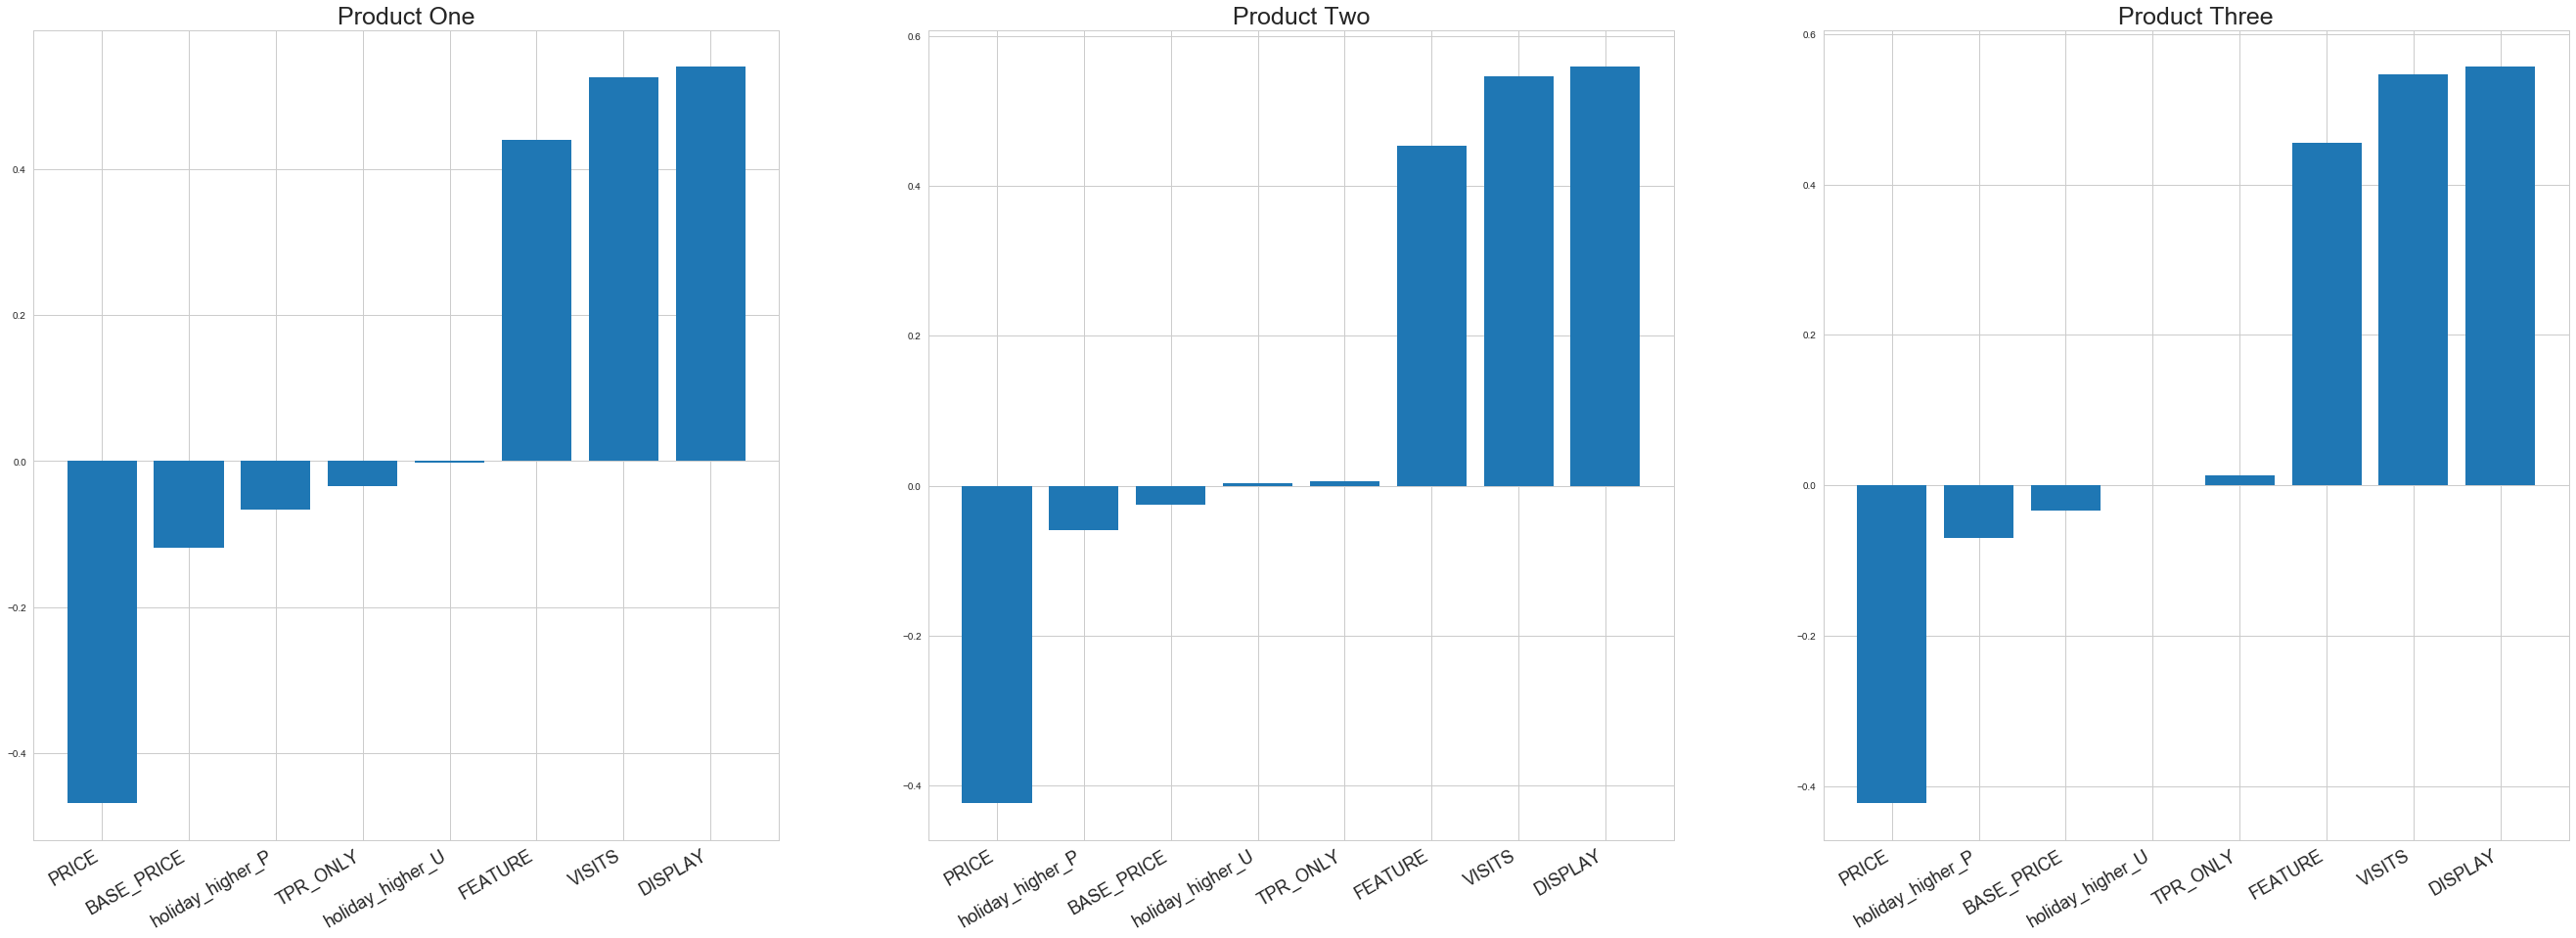

In [25]:
Visualisation_PCA_Weights(X_train_norm)

These three products show slightly different seleation result, but

The largest 1-5 contributors of information to the first component in order are same :
- VISITS
- DISPLAY
- FEATURE

And other five components are relavent less informative. 

The interesting thing is **price** is really unhelpful.

So I try the first five regressors first (They can explain up to 90% overall variation already)! 

### Calculate good combined components